# Solving SIR model with PINN

In [14]:
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
from kan import KAN

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN
from architectures import FNN, ResNet
from SIRData import CyclicSIRData
from utils import sample_collocation_points

## Generate Data from System

In [15]:
beta = 0.3
gamma = 1/21
theta = 1/90

X0 = torch.tensor([0.9999, 0.0001, 0.00])

In [16]:
time_int = [0, 60]
Nd = time_int[1]

# time_points = np.linspace(time_int[0], time_int[1], Nd+1, endpoint=True)[1:]
time_points = np.arange(time_int[0], time_int[1], 7)[1:]

# data = SIRData(X0, beta1, beta2, gamma1, gamma2, time_int, N=1000, time_points=time_points)
data = CyclicSIRData(X0, beta, gamma, theta, time_int, N=1000, time_points=time_points, noise_level=0.0)
td = data.td
Xd = data.Xd

In [17]:
# Boundary conditions
tbc = torch.tensor([[0.0]])
Xbc = X0.reshape(-1, 3)

In [18]:
# Collocation points
N_coll = 1000
tc = sample_collocation_points(N_coll, 1, lb=[time_int[0]], ub=[time_int[1]], method='grid')

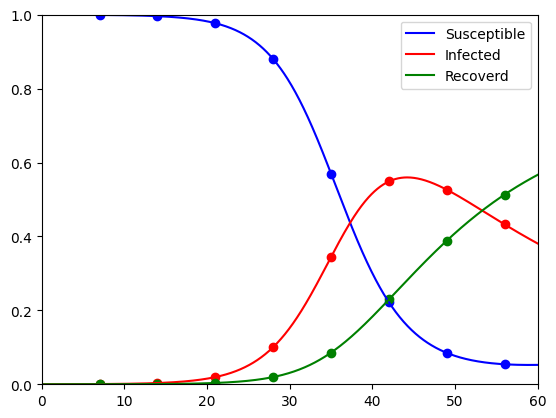

In [19]:
plt.plot(data.t_full, data.X_full[:,0], label='Susceptible', color='blue')
plt.plot(data.t_full, data.X_full[:,1], label='Infected', color='red')
plt.plot(data.t_full, data.X_full[:,2], label='Recoverd', color='green')
plt.scatter(td, data.Xd[:,0], color='blue')
plt.scatter(td, data.Xd[:,1], color='red')
plt.scatter(td, data.Xd[:,2], color='green')
plt.xlim(data.t_full[0], data.t_full[-1])
plt.ylim(0,1)
plt.legend()
plt.show()

### Known system $N_K$

In [20]:
class SIR(torch.nn.Module):
    
    def __init__(self, params):
        super(SIR, self).__init__()
        
        # Set the parameters
        for key, value in params.items():
            setattr(self, key, value) 

    def forward(self, z, U):

        lhs = torch.cat([
        torch.autograd.grad(outputs=U[:, i], inputs=z, grad_outputs=torch.ones_like(U[:, i]), create_graph=True)[0]
        for i in range(U.shape[1])
        ], dim=-1)

        S = U[:, 0]
        I = U[:, 1]
        R = U[:, 2]

        rhs = torch.stack([
            -self.beta*S*I,
            self.beta*S*I - self.gamma*I,
            self.gamma*I
        ], dim=-1)

        norm = torch.maximum(torch.abs(lhs), torch.abs(rhs)) + 1e-6

        return lhs - rhs


params = dict(
    beta=beta,
    gamma=gamma,
    theta=theta
)

N = SIR(params)

### Problem specific UPINN functions

In [21]:
phi = torch.nn.Parameter(torch.tensor(0.0))

class SIR_UPINN(UPINN):

    def score(self):
        u_pred = self.u(data.t_full)
        return torch.sqrt(torch.mean((u_pred - data.X_full)**2) / torch.mean(data.X_full**2))
    
    def F_input(self, z, U):
        return U
    

    def data_loss(self):
        u_pred = self.u(self.data_points[0])
        return torch.mean((u_pred[:, 1] - self.data_points[1][:, 1])**2)
    
    # def pde_loss(self):
    #     u_pred = self.u(self.collocation_points)
    #     known = self.N(self.collocation_points, u_pred)
    #     unknown = self.F(self.F_input(self.collocation_points, u_pred))
        
    # #     # res = torch.cat([-unknown[:, 0:1]+unknown[:, 2:3], unknown[:, 0:1]-unknown[:, 1:2], unknown[:, 1:2]-unknown[:, 2:3]], dim=-1)
    # #     # res = torch.cat([unknown[:, 2:3], 0*unknown[:, 1:2], -unknown[:, 2:3]], dim=-1)

    #     return torch.nn.MSELoss()(known, -unknown) + 1e-3*torch.mean(unknown**2)


    def plot(self, save=None):
        
        self.to('cpu')

        with torch.no_grad():
            # Get network predictions
            u_pred = self.u(data.t_full)

            plt.plot(data.t_full, data.X_full[:,0], label='S', linestyle='--', color='b')
            plt.plot(data.t_full, data.X_full[:,1], label='I', linestyle='--', color='y')
            plt.plot(data.t_full, data.X_full[:,2], label='R', linestyle='--', color='g')
            # plt.plot(data.t_full, data.X_full[:,3], label='R', linestyle='--', color='r')
            plt.plot(data.t_full, u_pred[:,0].numpy(), color='b')
            plt.plot(data.t_full, u_pred[:,1].numpy(), color='y')
            plt.plot(data.t_full, u_pred[:,2].numpy(), color='g')
            # plt.plot(data.t_full, u_pred[:,3].numpy(), color='r')
            plt.legend()
            plt.show()



### Setup UPINN

In [22]:
class SIRNet(FNN):
    def forward(self, z):
        z = (z - td.min()) / (td.max() - td.min())
        z = super().forward(z)
        # z = torch.nn.functional.softplus(z)
        return z / torch.sum(z, dim=1, keepdim=True)

# class SIRResidual(FNN):
#     def forward(self, z):
#         z = super().forward(z)
#         # Apply softplus to first and last component
#         z = torch.cat([torch.nn.functional.softplus(z[:,0:1]), torch.zeros_like(z[:,1:2]), z[:,1:2], -torch.nn.functional.softplus(z[:,-1:])], dim=1)
#         return z

class SIRResidual(FNN):
    def forward(self, z):
        z = super().forward(z)
        z = torch.cat([z[:,0:1]-z[:,1:2], z[:,1:2]-z[:,2:3], z[:,2:3]-z[:,0:1]], dim=1)
        return z



In [23]:
# Define model architectures
hidden = [16] * 3
u = SIRNet(
    dims=[1, *hidden, 3],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Softmax(),
)

hiddenF = [16] * 3
F = FNN(
    dims=[3, *hiddenF, 3],
    hidden_act=torch.nn.Tanh(),
)
# F = SIRResidual(
#     dims=[3, *hiddenF, 3],
#     hidden_act=torch.nn.Tanh(),
# )

# u = KAN([1, 3, 3], grid=5)
# F = KAN([3, 3, 3], grid=5)

In [24]:
model = SIR_UPINN(u, N, F, boundary_points=(tbc, Xbc), data_points=(td, Xd), collocation_points=tc)

[Info]: Initializing UPINN model


### Train

In [25]:
adamw = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
model.optimizer = adamw

In [26]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adamw, factor=0.5, patience=500, threshold=1e-3)
model.scheduler = scheduler

In [ ]:
model.train_loop(50000, device='cpu')
model.plot()

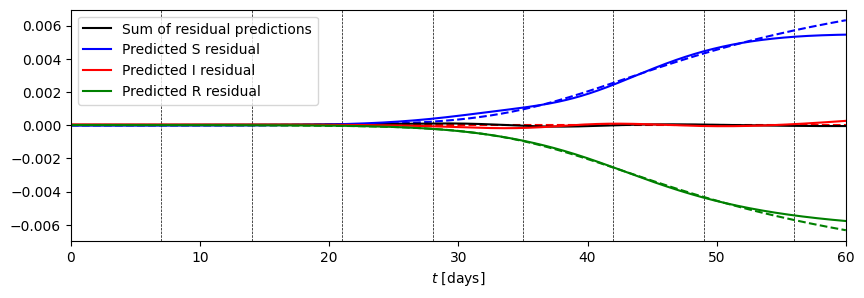

In [ ]:
model.to('cpu')
u_pred = model.u(data.t_full)
S = u_pred[:,0].detach().numpy()
I = u_pred[:,1].detach().numpy()
R = u_pred[:,2].detach().numpy()
res_pred = -model.F(model.F_input(data.t_full, u_pred)).detach().numpy()

plt.figure( figsize=(10, 3))
for t in data.td:
    plt.axvline(t, color='black', linestyle='--', linewidth=0.5)
plt.plot(data.t_full, theta*R, color='blue', linestyle='--')
plt.plot(data.t_full, 0*R, color='red', linestyle='--')
plt.plot(data.t_full, -theta*R, color='green', linestyle='--')
plt.plot(data.t_full, res_pred[:,0]+res_pred[:,1]+res_pred[:,2], label='Sum of residual predictions', color='black')
plt.plot(data.t_full, res_pred[:,0], label='Predicted S residual', color='blue')
plt.plot(data.t_full, res_pred[:,1], label='Predicted I residual', color='red')
plt.plot(data.t_full, res_pred[:,2], label='Predicted R residual', color='green')
plt.xlim(data.t_full[0], data.t_full[-1])
plt.xlabel(r'$t$ [days]')
plt.legend()
plt.show()

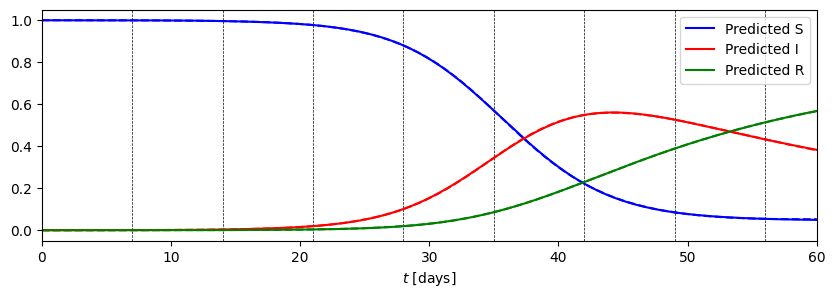

In [38]:
model.to('cpu')
u_pred = model.u(data.t_full)
S = u_pred[:,0].detach().numpy()
I = u_pred[:,1].detach().numpy()
R = u_pred[:,2].detach().numpy()

plt.figure( figsize=(10, 3))
for t in data.td:
    plt.axvline(t, color='black', linestyle='--', linewidth=0.5)
plt.plot(data.t_full, S, label='Predicted S', color='blue')
plt.plot(data.t_full, I, label='Predicted I', color='red')
plt.plot(data.t_full, R, label='Predicted R', color='green')
plt.plot(data.t_full, data.X_full[:, 0], color='blue', linestyle='--')
plt.plot(data.t_full, data.X_full[:, 1], color='red', linestyle='--')
plt.plot(data.t_full, data.X_full[:, 2], color='green', linestyle='--')
# plt.xlim(data.t_full[0], data.t_full[-1])
plt.xlim(data.t_full[0], data.t_full[-1])
plt.xlabel(r'$t$ [days]')
plt.legend()
plt.savefig('gfx/sir_recycle_solution.pdf', bbox_inches='tight', format='pdf')
plt.show()